In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydataset import data
import sklearn

import warnings
warnings.filterwarnings("ignore")

import feature_selection
from sklearn.metrics import mean_squared_error

from sklearn.metrics import explained_variance_score

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [48]:
# print(data().to_markdown())

In [2]:
df = data('urine')

In [3]:
data('urine', show_doc=True)

urine

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

##  Urine Analysis Data

### Description

The `urine` data frame has 79 rows and 7 columns.

79 urine specimens were analyzed in an effort to determine if certain physical
characteristics of the urine might be related to the formation of calcium
oxalate crystals.

### Usage

    urine

### Format

This data frame contains the following columns:

`r`

Indicator of the presence of calcium oxalate crystals.

`gravity`

The specific gravity of the urine.

`ph`

The pH reading of the urine.

`osmo`

The osmolarity of the urine. Osmolarity is proportional to the concentration
of molecules in solution.

`cond`

The conductivity of the urine. Conductivity is proportional to the
concentration of charged ions in solution.

`urea`

The urea concentration in millimoles per litre.

`calc`

The calcium concentration in millimoles per litre.

### Source

The data were obtained from

Andrews, D.F. and Herzb

In [4]:
df.osmo = df.osmo.fillna(df.osmo.mean())

In [5]:
df.cond = df.cond.fillna(df.cond.mean())

In [6]:
# Split the data
train, validate, test = feature_selection.split(df, stratify_by="urea")

# Setup X and y
X_train = train.drop(columns='urea')
y_train = train.urea

X_validate = validate.drop(columns='urea')
y_validate = validate.urea

X_test = test.drop(columns='urea')
y_test = test.urea

In [7]:
# Scale the data
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit the scaler
scaler.fit(X_train)

# Use the scaler to transform train, validate, test
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)


# Turn everything into a dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_validate_scaled = pd.DataFrame(X_validate_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [8]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   r        44 non-null     float64
 1   gravity  44 non-null     float64
 2   ph       44 non-null     float64
 3   osmo     44 non-null     float64
 4   cond     44 non-null     float64
 5   calc     44 non-null     float64
dtypes: float64(6)
memory usage: 2.2 KB


In [9]:
from sklearn.feature_selection import SelectKBest

In [10]:
# Find the top 3 features using kbest
feature_selection.select_kbest(X_train_scaled, y_train, 3)

['gravity', 'osmo', 'cond']

In [11]:
# Find the top 3 features using RFE
selected_features, all_rankings = feature_selection.select_rfe(X_train, y_train, 3)
print(selected_features)
all_rankings

['r', 'gravity', 'cond']


,Var,Rank
0,r,1
1,gravity,1
4,cond,1
3,osmo,2
5,calc,3
2,ph,4


In [12]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [13]:
# 1. Predict urea_pred_mean
urea_pred_mean = y_train.urea.mean()
y_train['urea_pred_mean'] = urea_pred_mean
y_validate['urea_pred_mean'] = urea_pred_mean

In [14]:
# 2. compute urea_pred_median
urea_pred_median = y_train.urea.median()
y_train['urea_pred_median'] = urea_pred_median
y_validate['urea_pred_median'] = urea_pred_median

In [15]:
# 3. RMSE of urea_pred_mean
rmse_train = mean_squared_error(y_train.urea,
                                y_train.urea_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.urea, y_validate.urea_pred_mean) ** (1/2)

In [16]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  125.89 
Validate/Out-of-Sample:  148.24


In [17]:
# 4. RMSE of urea_pred_median
rmse_train = mean_squared_error(y_train.urea, y_train.urea_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.urea, y_validate.urea_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  126.33 
Validate/Out-of-Sample:  150.55


In [18]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [19]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.urea,
                           y_train.urea_pred_mean,
                           'mean_baseline',
                          metric_df)

In [20]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,125.885088,2.220446e-16


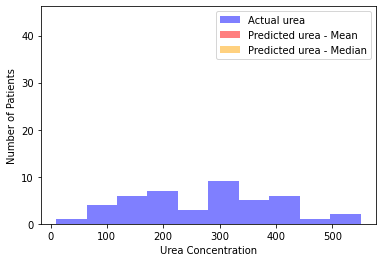

In [21]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.urea, color='blue', alpha=.5, label="Actual urea")
plt.hist(y_train.urea_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted urea - Mean")
plt.hist(y_train.urea_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted urea - Median")
plt.xlabel("Urea Concentration")
plt.ylabel("Number of Patients")
plt.legend()
plt.show()

### LinearRegression (OLS)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for Providences in training sample using our model (lm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [22]:
y_train.head()

,urea,urea_pred_mean,urea_pred_median
61,385,272.386364,283.0
17,133,272.386364,283.0
8,550,272.386364,283.0
74,418,272.386364,283.0
69,396,272.386364,283.0


In [23]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

In [24]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.urea)

LinearRegression(normalize=True)

In [25]:
# predict train
# 
# use the thing!
# 
y_train['urea_pred_lm'] = lm.predict(X_train)

In [26]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.urea, y_train.urea_pred_lm) ** (1/2)

# predict validate
y_validate['urea_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.urea, y_validate.urea_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  32.68098735203839 
Validation/Out-of-Sample:  37.97732181108538


In [27]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.urea, y_validate.urea_pred_lm)}, ignore_index=True)

In [28]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,125.885088,2.220446e-16
1,OLS Regressor,37.977322,9.393194e-01


### LassoLars

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for Providences in training sample using our model (lars). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [29]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.urea)

# predict train
y_train['urea_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.urea, y_train.urea_pred_lars) ** (1/2)

# predict validate
y_validate['urea_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.urea, y_validate.urea_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  45.13415557129728 
Validation/Out-of-Sample:  55.61944185941246


In [30]:
metric_df = make_metric_df(y_validate.urea,
               y_validate.urea_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [31]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,125.885088,2.220446e-16
1,OLS Regressor,37.977322,9.393194e-01
2,lasso_alpha_1,55.619442,8.562646e-01


### TweedieRegressor (GLM)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for Providences in training sample using our model (glm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [32]:
from sklearn.linear_model import TweedieRegressor

In [33]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.urea)

# predict train
y_train['urea_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.urea, y_train.urea_pred_glm) ** (1/2)

# predict validate
y_validate['urea_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.urea, y_validate.urea_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  125.88508755446391 
Validation/Out-of-Sample:  148.239657874712


In [34]:
metric_df = make_metric_df(y_validate.urea,
               y_validate.urea_pred_glm,
               'glm_poisson',
               metric_df)

In [35]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,125.885088,2.220446e-16
1,OLS Regressor,37.977322,9.393194e-01
2,lasso_alpha_1,55.619442,8.562646e-01
3,glm_poisson,148.239658,0.000000e+00


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test. 

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

## **PolynomialFeatures**

In [36]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

## **LinearRegression**

In [37]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.urea)

# predict train
y_train['urea_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.urea, y_train.urea_pred_lm2) ** (1/2)

# predict validate
y_validate['urea_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.urea, y_validate.urea_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  39.38648822306267 
Validation/Out-of-Sample:  135.3842484812842


In [38]:
metric_df = make_metric_df(y_validate.urea,
               y_validate.urea_pred_lm2,
               'quadratic',
               metric_df)

In [39]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,125.885088,2.220446e-16
1,OLS Regressor,37.977322,9.393194e-01
2,lasso_alpha_1,55.619442,8.562646e-01
3,glm_poisson,148.239658,0.000000e+00
4,quadratic,135.384248,2.009048e-01


### Evaluate

**Plotting Actual vs. Predicted Values**

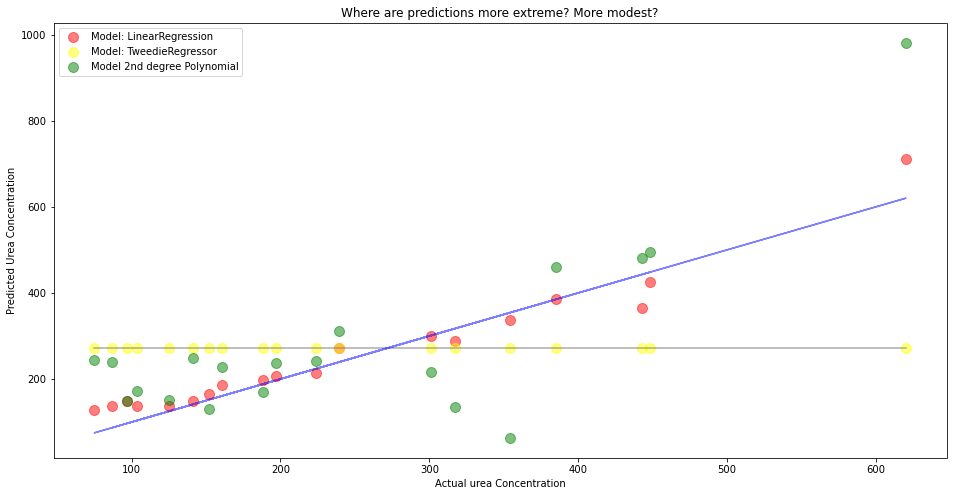

In [40]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.urea, y_validate.urea_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.plot(y_validate.urea, y_validate.urea, alpha=.5, color="blue", label='_nolegend_')

plt.scatter(y_validate.urea, y_validate.urea_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.urea, y_validate.urea_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.urea, y_validate.urea_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual urea Concentration")
plt.ylabel("Predicted Urea Concentration")
plt.title("Where are predictions more extreme? More modest?")

plt.show()

**Residual Plots: Plotting the Errors in Predictions**

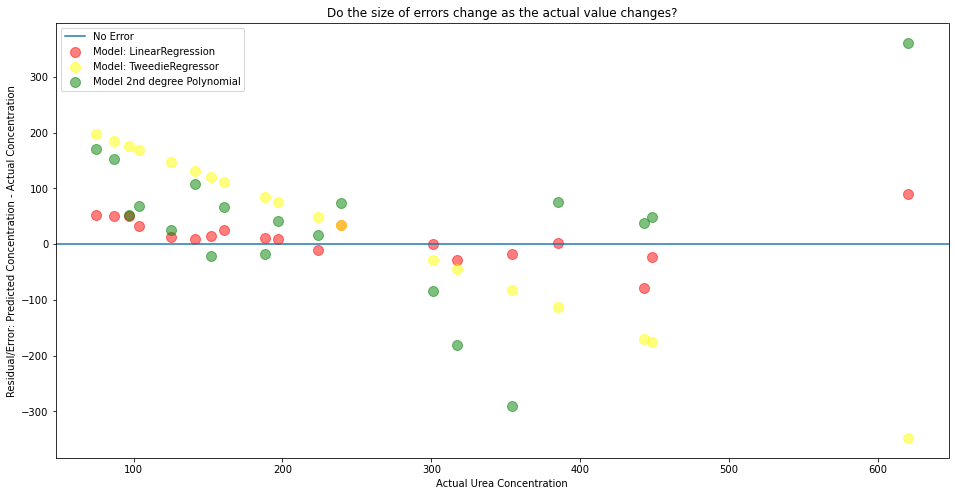

In [41]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.urea, y_validate.urea_pred_lm - y_validate.urea , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.urea, y_validate.urea_pred_glm - y_validate.urea, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.urea, y_validate.urea_pred_lm2 - y_validate.urea, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Urea Concentration")
plt.ylabel("Residual/Error: Predicted Concentration - Actual Concentration")
plt.title("Do the size of errors change as the actual value changes?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Histograms**

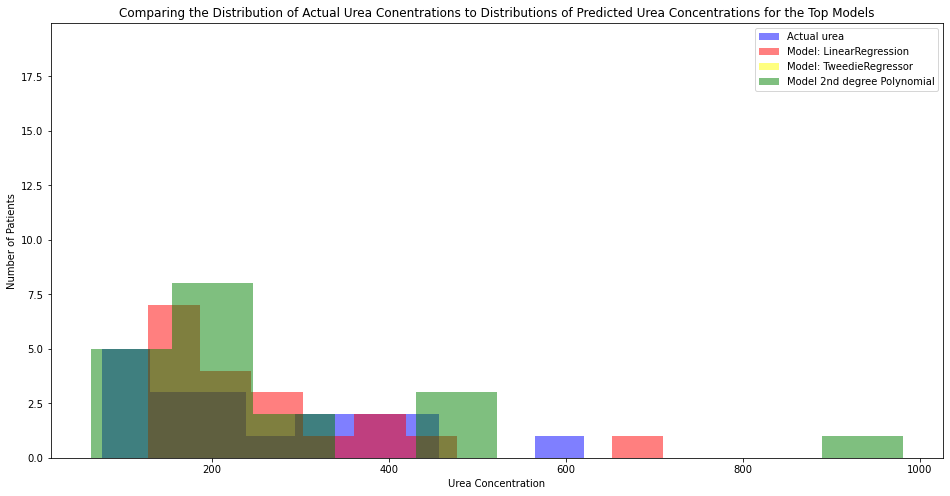

In [42]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.urea, color='blue', alpha=.5, label="Actual urea")
plt.hist(y_validate.urea_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.urea_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.urea_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Urea Concentration")
plt.ylabel("Number of Patients")
plt.title("Comparing the Distribution of Actual Urea Conentrations to Distributions of Predicted Urea Concentrations for the Top Models")
plt.legend()
plt.show()

In [43]:
# addendum: Comparing models DF:

In [46]:
metric_df[['model', 'RMSE_validate']]

,model,RMSE_validate
0,mean_baseline,125.885088
1,OLS Regressor,37.977322
2,lasso_alpha_1,55.619442
3,glm_poisson,148.239658
4,quadratic,135.384248


**Model Selection & Out-of-Sample Evaluation**

Model selected: lm (using LinearRegression)

In [45]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['urea_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.urea, y_test.urea_pred_lm) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  26.134040344916166
